In [ ]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import simulation
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd
from importlib import resources

In [2]:
#autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
f_coeffs_path = (
    resources.files("CoPhaser") / "ressources" / "fourier_coefficients_RPE.csv"
)
f_coeffs = pd.read_csv(f_coeffs_path, index_col=0)

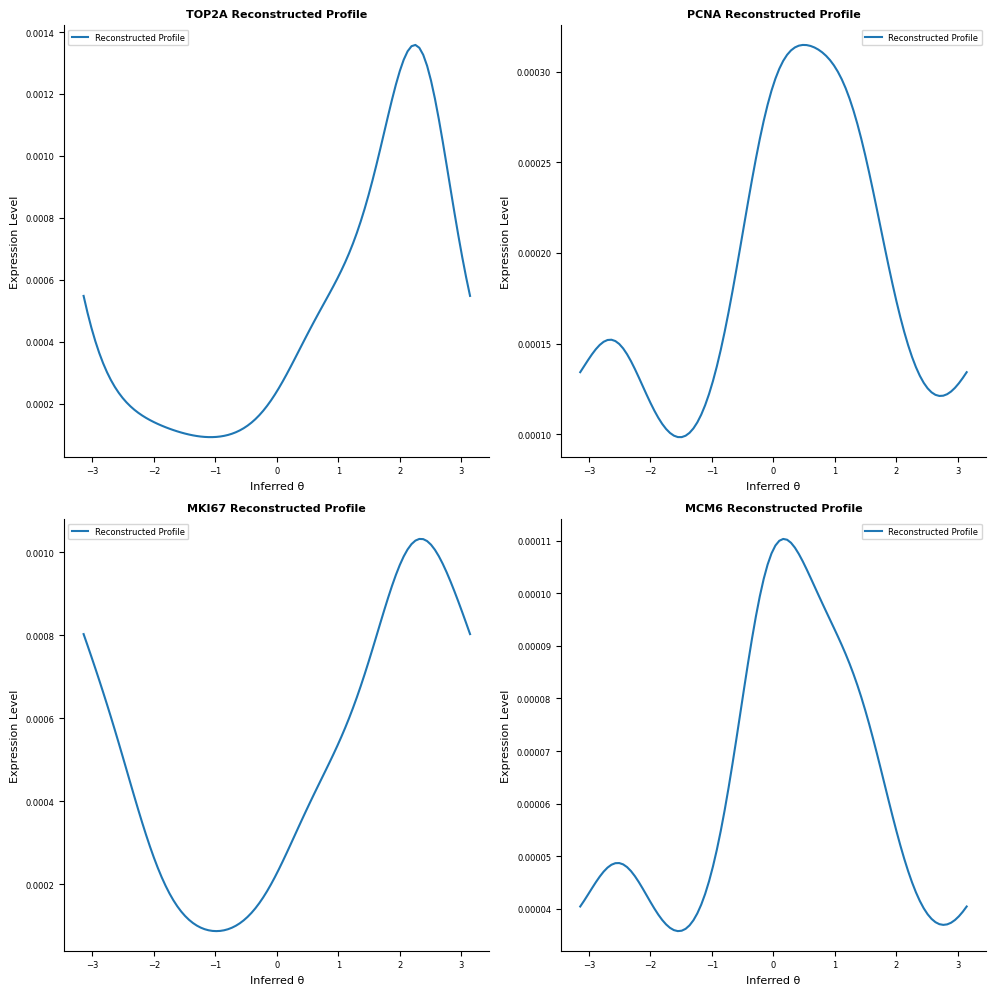

In [4]:
# draw reconstructed profiles for TOP2A, PCNA, MKI67, MCM6
genes_to_plot = ["TOP2A", "PCNA", "MKI67", "MCM6"]
ncols = 2
nrows = np.ceil(len(genes_to_plot) / ncols).astype(int)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
axs = axs.flatten()
for i, gene in enumerate(genes_to_plot):
    if i >= len(axs):
        break
    A_0 = f_coeffs.loc[gene, "A_0"]
    A_1 = f_coeffs.loc[gene, "A_1"]
    B_1 = f_coeffs.loc[gene, "B_1"]
    A_2 = f_coeffs.loc[gene, "A_2"]
    B_2 = f_coeffs.loc[gene, "B_2"]
    A_3 = f_coeffs.loc[gene, "A_3"]
    B_3 = f_coeffs.loc[gene, "B_3"]

    theta_vals = np.linspace(-np.pi, np.pi, 100)
    reconstructed_profile = (
        A_0
        + A_1 * np.cos(theta_vals)
        + B_1 * np.sin(theta_vals)
        + A_2 * np.cos(2 * theta_vals)
        + B_2 * np.sin(2 * theta_vals)
        + A_3 * np.cos(3 * theta_vals)
        + B_3 * np.sin(3 * theta_vals)
    )
    reconstructed_profile = np.exp(reconstructed_profile)

    axs[i].plot(theta_vals, reconstructed_profile, label="Reconstructed Profile")
    axs[i].set_title(f"{gene} Reconstructed Profile")
    axs[i].set_xlabel("Inferred θ")
    axs[i].set_ylabel("Expression Level")
    axs[i].legend()
plt.tight_layout()

In [5]:
n_cells = 10000
fraction_cycling = 1
pseudotimes = np.linspace(0, 1, int(fraction_cycling * n_cells))

<Axes: xlabel='A_0', ylabel='Count'>

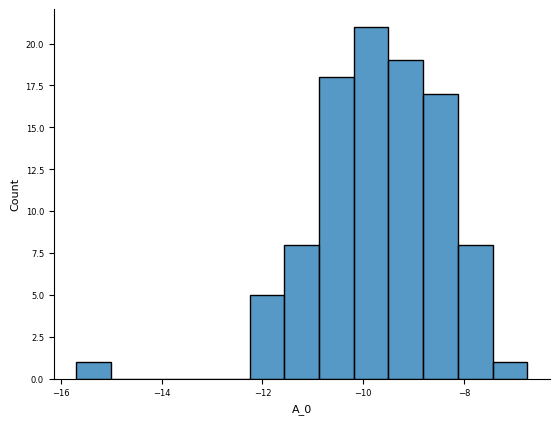

In [6]:
sns.histplot(f_coeffs["A_0"])

In [7]:
f_coeffs

,A_1,B_1,A_2,B_2,A_3,B_3,A_0
ANLN,-0.638664,0.610863,0.128453,0.153707,0.058234,-0.042431,-8.773448
ANP32E,-0.298055,0.116030,0.096229,0.023839,0.062986,-0.059882,-8.806296
ATAD2,0.265067,0.607128,0.283350,0.219546,0.034773,-0.138012,-9.213545
AURKA,-1.228139,0.821817,0.231476,0.033464,0.009242,-0.031599,-9.249946
AURKB,-0.580362,1.263822,0.175406,0.196419,0.018040,0.057942,-10.505713
...,...,...,...,...,...,...,...
UBR7,0.097186,0.465822,0.126975,0.117577,-0.000561,-0.046522,-10.523674
UHRF1,0.130008,0.293884,0.318009,0.097990,0.053321,-0.056633,-10.054288
UNG,0.803291,-0.085183,0.207374,0.257812,0.032495,-0.153009,-10.337291
USP1,0.252775,0.540631,0.214070,-0.003635,0.023438,-0.122093,-8.809962


In [ ]:
to_save = {}

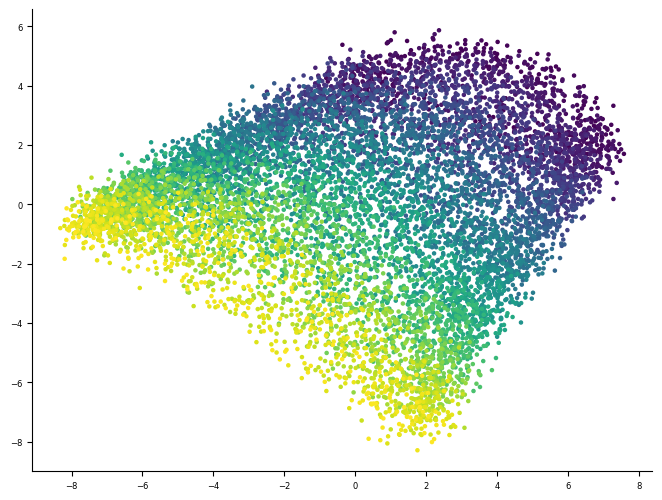

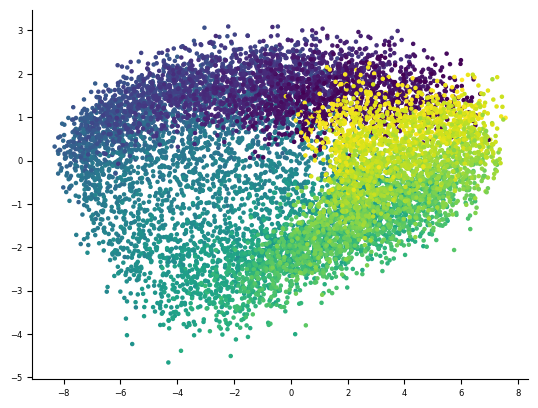

In [11]:
# PCA on simulated counts
from sklearn.decomposition import PCA

np.random.seed(0)
f_coeffs["A_0_DIFF"] = f_coeffs["A_0"]
f_coeffs.loc[::3, "A_0_DIFF"] = f_coeffs.loc[::3, "A_0"] + np.random.uniform(
    -5, 5, size=f_coeffs.loc[::3, "A_0"].shape[0]
)
f_coeffs.loc["TOP2A", "A_0_DIFF"] = f_coeffs.loc["TOP2A", "A_0"] + 2.5
# + np.random.uniform(
#     -3, 3, size=f_coeffs.loc[:,"A_0"].shape[0]
# )
lambda_start = 0.8
lambda_end = 1.7
rhythmic_counts, phases, fractions, mu_gt = (
    simulation.simulate_counts_rhythmic_shifting(
        fourrier_coefficients=f_coeffs,
        n_cells=int(n_cells * fraction_cycling),
        alphas=0.1,
        library_size=1e4,
        lambda_=(lambda_start, lambda_end),
        pseudotimes=pseudotimes,
    )
)
# mean_expression = (
#     # np.array(rhythmic_counts.mean(axis=0)).squeeze()
#     # / 1e4
#     2
#     ** np.random.uniform(-10, -14, size=rhythmic_counts.shape[1])
# )
# mu_gt_not_cycling = np.tile(mean_expression, (int(n_cells * (1 - fraction_cycling)), 1))
# counts_not_cycling = simulation.simulate_counts(mu_gt_not_cycling)
# fractions_not_cycling = mu_gt_not_cycling.sum(axis=1) / 1e4
# rhythmic_counts = vstack([rhythmic_counts, counts_not_cycling])
# phases = np.concatenate([phases, [np.nan] * counts_not_cycling.shape[0]])
# mu_gt_not_cycling = np.tile(mu_gt_not_cycling[:, :, None], (1, 1, 100))
# mu_gt = np.vstack([mu_gt, mu_gt_not_cycling])

# rhythmic_counts[1::10, :] = scipy.sparse.csr_matrix(np.random.default_rng(seed=0).permuted(rhythmic_counts[1::10, :].toarray(), axis=0))
pca = PCA(n_components=5)
pca_results = pca.fit_transform(np.log1p(rhythmic_counts / 10000 * 1e4))
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    pca_results[:, 0],
    pca_results[:, 1],
    c=pseudotimes,
    s=5,
)
plt.show()
plt.scatter(
    pca_results[:, 0],
    pca_results[:, 2],
    c=phases,
    s=5,
)

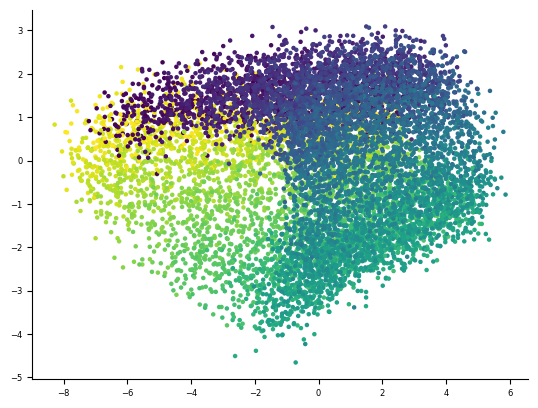

In [12]:
plt.scatter(
    pca_results[:, 1],
    pca_results[:, 2],
    c=phases,
    s=5,
)

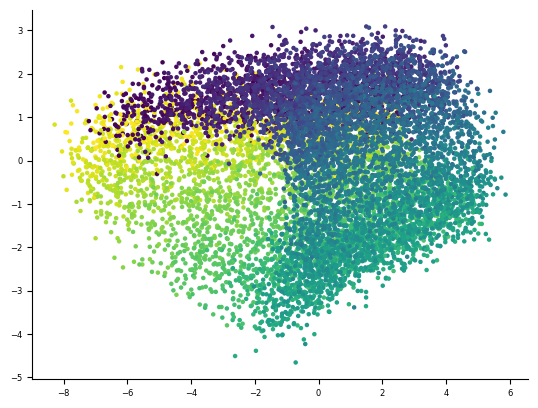

In [13]:
plt.scatter(
    pca_results[:, 1],
    pca_results[:, 2],
    c=phases,
    s=5,
)

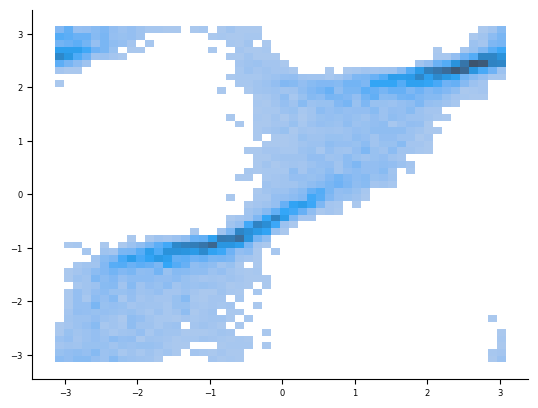

In [14]:
pca_phases = np.arctan2(pca_results[:, 0], pca_results[:, 2])
results_shifts = simulation.get_best_shift_direction(pca_phases, phases)
pca_phases = utils.normalize_angles(
    pca_phases * results_shifts["direction"] - results_shifts["shift"]
)
sns.histplot(y=pca_phases, x=phases, bins=50)
to_save["PCA"] = {
    "pca_phases": pca_phases,
    "phases": phases,
    "pseudotimes": pseudotimes,
    "PC_1": pca_results[:, 0],
    "PC_3": pca_results[:, 2],
}

In [12]:
n_variable_genes = 2000
fold_changes = np.random.uniform(-3, 3, size=n_variable_genes)
non_rhythmic_counts, base_fraction_unscaled = (
    simulation.generate_gradual_shifting_counts(
        n_genes=10000,
        n_cells=int(n_cells * fraction_cycling),
        fold_changes=fold_changes,
        target_fractions=1 - fractions,
        alphas=0.1,
        library_size=1e4,
        pseudotimes=pseudotimes,
    )
)
# fold_changes = np.random.uniform(-8, 2, size=n_variable_genes)
# non_rhythmic_counts_shifted = simulation.generate_differently_expressed_counts(
#     n_genes=10000,
#     n_cells=int(n_cells * (1 - fraction_cycling)),
#     fold_changes=fold_changes,
#     base_fractions_unscaled=base_fraction_unscaled,
#     target_fractions=1 - fractions_not_cycling,
#     alphas=0.1,
#     library_size=1e4,
# )

# non_rhythmic_counts = vstack(
#     [non_rhythmic_counts_gradient, non_rhythmic_counts_shifted]
# )

(10000, 10000) (10000,)


<Axes: ylabel='Count'>

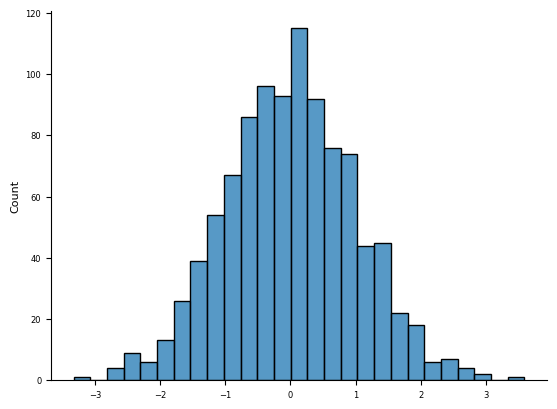

In [13]:
sns.histplot(np.random.normal(0, 1, 1000))

In [14]:
# combine in a csr matrix the two count matrices


combined_counts = hstack([rhythmic_counts, non_rhythmic_counts]).tocsr()
combined_counts.shape

(10000, 10098)

<Axes: >

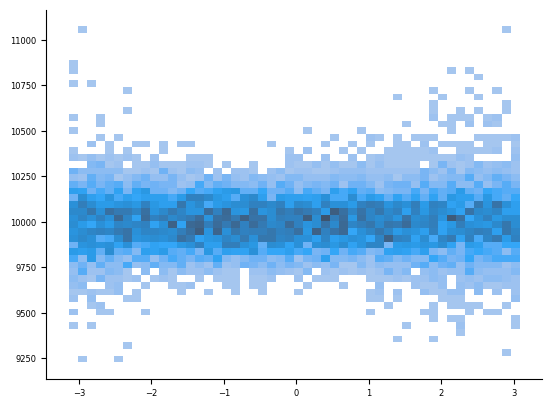

In [15]:
sns.histplot(x=phases, y=combined_counts.sum(axis=1).A1, bins=50)

Text(0.5, 1.0, 'Distribution of Fold Changes in Non-Rhythmic Genes')

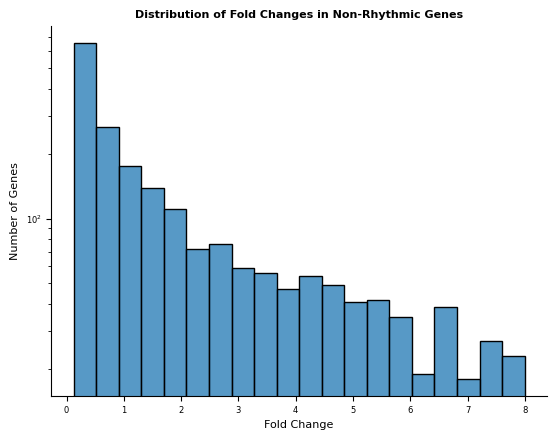

In [16]:
sns.histplot(2**fold_changes)
plt.yscale("log")
plt.xlabel("Fold Change")
plt.ylabel("Number of Genes")
plt.title("Distribution of Fold Changes in Non-Rhythmic Genes")

In [17]:
adata = anndata.AnnData(X=combined_counts)
var_names = [f"GENE_{i}" for i in range(combined_counts.shape[1])]
var_names[: len(f_coeffs)] = f_coeffs.index.tolist()
var_names[len(f_coeffs) : len(f_coeffs) + n_variable_genes] = [
    f"VARIABLE_GENE_{i}" for i in range(n_variable_genes)
]
adata.var_names = var_names
adata.layers["counts"] = adata.X.copy()

In [18]:
variable_genes = adata.var_names[len(f_coeffs) : len(f_coeffs) + n_variable_genes]
rhythmic_genes = adata.var_names[: len(f_coeffs)]

In [19]:
def grid_search(
    closed_circle_weight=[20, 30],
    MI_weights=[100],
    entropy_weight_factor=[200, 300],
):
    results = {"ccw": [], "miw": [], "ewf": [], "rep": [], "results": []}
    # convert to a single for loop and use itertools.product and add an iter bar
    import itertools
    import tqdm

    for params in tqdm.tqdm(
        itertools.product(
            closed_circle_weight, MI_weights, entropy_weight_factor, range(6)
        ),
        total=len(closed_circle_weight)
        * len(MI_weights)
        * len(entropy_weight_factor)
        * 6,
    ):
        ccw, miw, ewf, rep = params
        model = CoPhaser(
            rhythmic_genes,
            variable_genes,
            n_latent=2,
        )
        model.load_anndata(adata, layer_to_use="counts")
        trainer = Trainer(
            model,
            Loss.compute_loss,
            noise_model="NB",
            non_rhythmic_likelihood_weight=1,
            rhythmic_likelihood_weight=1,
            L2_Z_decoder_loss_weight=0,
            closed_circle_weight=ccw,
            cycling_status_prior=1,
            MI_weight=miw,
            entropy_weight_factor=ewf,
        )
        trainer.train_model(
            n_epochs=200,
            lr=1e-2,
            device="cuda",
            batch_size=1024,
            ,
            silent=True,
        )
        model.to("cpu")
        generative_outputs, space_outputs = model.get_outputs()
        thetas = space_outputs["theta"]
        results_shifts = simulation.get_best_shift_direction(thetas, phases)
        mu_pred, theta_pred = simulation.get_mu_pred(
            model,
            generative_outputs,
            space_outputs,
            results_shifts,
            n_theta=mu_gt.shape[2],
        )
        pearson_per_cell_genes = pearsonr(np.log2(mu_pred), np.log2(mu_gt), axis=-1)[0]
        pearson_per_cell_genes[:, model.rhythmic_gene_names != "FEN1"].mean()
        results["ccw"].append(ccw)
        results["miw"].append(miw)
        results["ewf"].append(ewf)
        results["rep"].append(rep)
        results["results"].append(pearson_per_cell_genes.mean())
    results = pd.DataFrame.from_dict(results)
    return results


# res = grid_search()
# res

In [20]:
# (res["results"] > 0.8).mean()

Epoch 1/200, elbo_loss: 6451.1801, kl_div_f: 4.6796, kl_div_z: 4528.9864, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -2.7001, entropy_loss: -540.0203, radial_variance: 17.7057, radius: 26.3239, L1_mu_z: 0.0000, MI_loss: 0.0000, total_loss: 5955.1891
Epoch 2/200, elbo_loss: 1865.2679, kl_div_f: 4.6286, kl_div_z: 8.2194, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.2904, entropy_loss: -658.0822, radial_variance: 11.4279, radius: 15.7139, L1_mu_z: 0.0000, MI_loss: -0.0000, total_loss: 1234.3275
Epoch 3/200, elbo_loss: 1820.8405, kl_div_f: 4.5669, kl_div_z: 8.2116, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.3470, entropy_loss: -669.4046, radial_variance: 2.8378, radius: 6.5503, L1_mu_z: 0.0000, MI_loss: -0.0000, total_loss: 1160.8239
Epoch 4/200, elbo_loss: 1783.9350, kl_div_f: 4.5020, kl_div_z: 8.2116, fraction_cycling_cells: 1.0000, l2_px_rate: 0.0000, entropy_loss_unweighted: -3.381

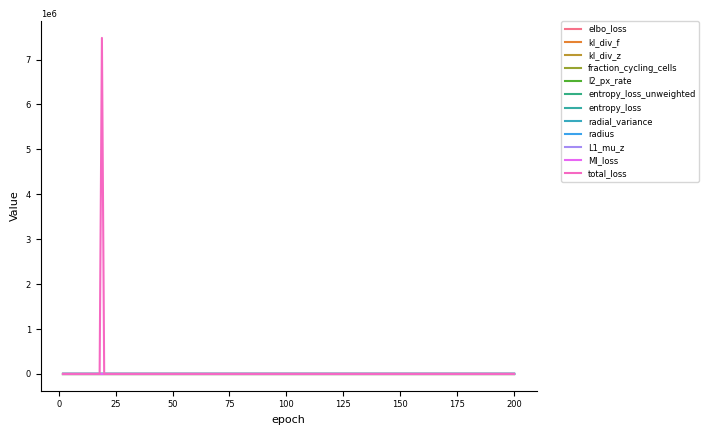

In [41]:
model = CoPhaser(
    rhythmic_genes,
    variable_genes,
    n_latent=2,
    use_mu_z_encoder=False,
    use_amp_Z=False,
    z_range=0.01,
    use_latent_z=False,
)
model.load_anndata(adata, layer_to_use="counts")
trainer = Trainer(
    model,
    Loss.compute_loss,
    noise_model="NB",
    non_rhythmic_likelihood_weight=0.1,
    rhythmic_likelihood_weight=10,
    L2_Z_decoder_loss_weight=0,
    closed_circle_weight=30,
    cycling_status_prior=1,
    MI_weight=1,
    entropy_weight_factor=200,
)
trainer.train_model(
    n_epochs=200,
    lr=1e-2,
    device="cuda",
    batch_size=1024,
    ,
)
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"]
results_shifts = simulation.get_best_shift_direction(thetas, phases)
thetas = utils.normalize_angles(
    results_shifts["direction"] * thetas - results_shifts["shift"]
)
mu_pred, theta_pred = simulation.get_mu_pred(
    model, generative_outputs, space_outputs, results_shifts, n_theta=mu_gt.shape[2]
)
theta_pred = theta_pred * results_shifts["direction"] - results_shifts["shift"]

<Axes: ylabel='Count'>

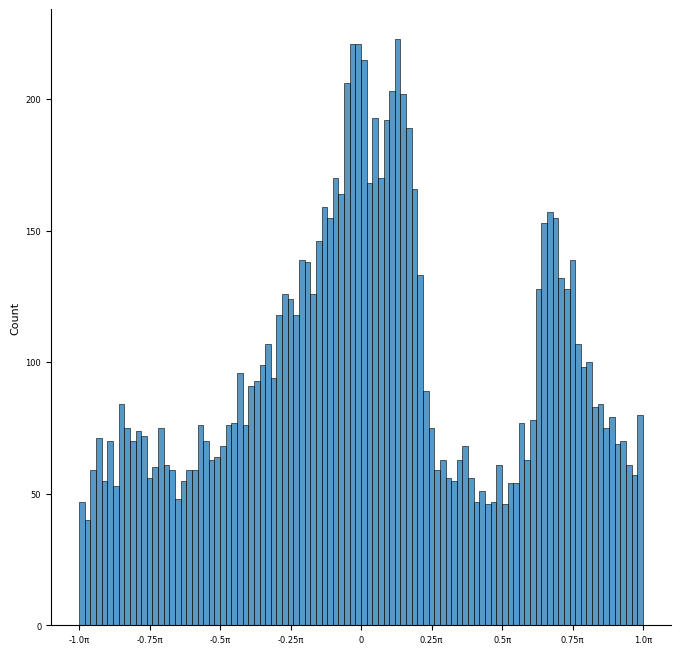

In [66]:
# Get the infered theta values
model.to("cpu")
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"]
plotting.modify_axis_labels()
sns.histplot(thetas, bins=100)

<Axes: label='B'>

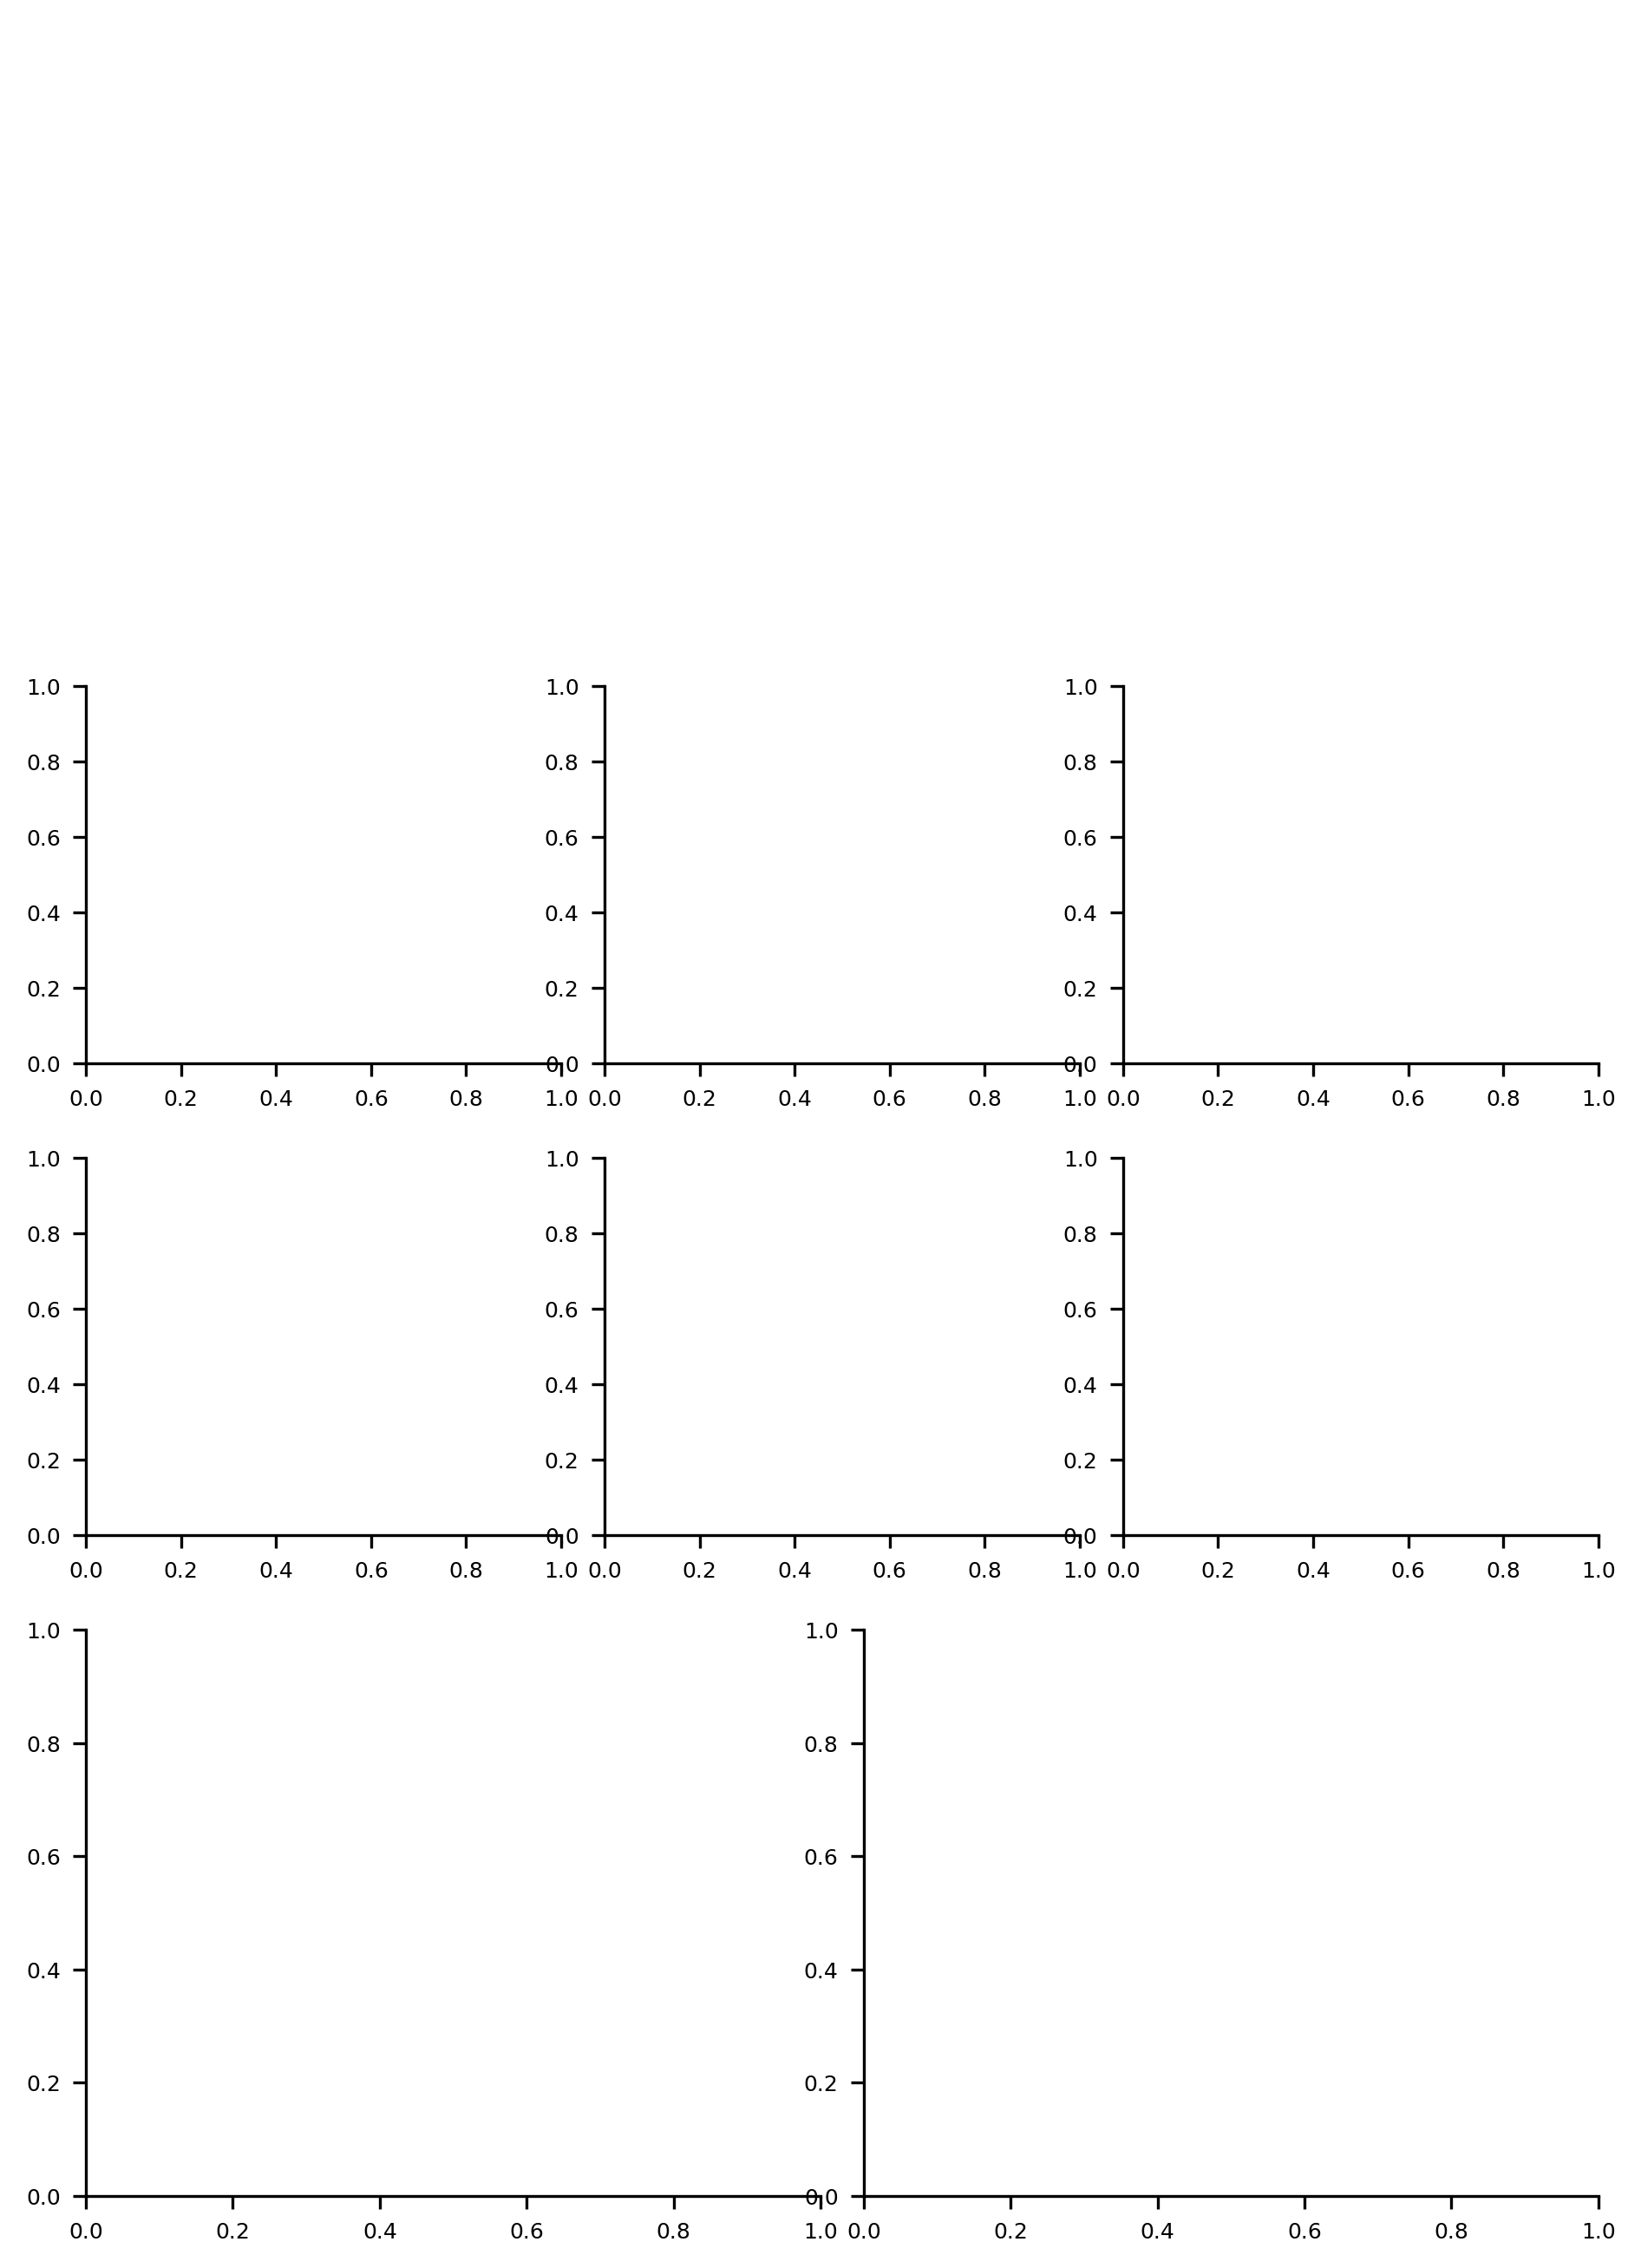

In [67]:
mosaic = [["A", "B"], ["C", "D", "E"], ["F", "G", "H"], ["I", "J"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=20)
plot_helpers.make_blank_panel(axs["A"])
plot_helpers.make_blank_panel(axs["B"])

In [68]:
for ax in [
    axs["C"],
    axs["D"],
    axs["E"],
    axs["F"],
    axs["G"],
    axs["H"],
    axs["I"],
    axs["J"],
]:
    ax.set_box_aspect(1)

In [69]:
results_shifts = simulation.get_best_shift_direction(thetas, phases)
thetas = utils.normalize_angles(
    results_shifts["direction"] * thetas - results_shifts["shift"]
)

In [70]:
lambda_vals = (1 - pseudotimes) * lambda_start + pseudotimes * lambda_end
ax = axs["C"]
cmap = sns.cubehelix_palette(as_cmap=True)
scatter = ax.scatter(
    space_outputs["z"][:, 0],
    space_outputs["z"][:, 1],
    c=pseudotimes,
    edgecolor=None,
    s=5,
    alpha=0.5,
    cmap=cmap,
)
import matplotlib.cm as cm

norm = plt.Normalize(vmin=pseudotimes.min(), vmax=pseudotimes.max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label="Pseudotime")
cbar.ax.set_yticklabels([])
ax.set_title("z Space")
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("z1")
ax.set_ylabel("z2")

Text(13.33333333333329, 0.5, 'z2')

In [71]:
cells_projected = space_outputs["x_projected"].detach().numpy()
ax = axs["D"]
sns.scatterplot(
    x=cells_projected[:, 0],
    y=cells_projected[:, 1],
    ax=ax,
    alpha=0.2,
    edgecolor=None,
    s=2,
    c=thetas,
    cmap="hsv",
)
ax.set_title("f Space")
# remove ticks
ax.set_xticks([])
ax.set_yticks([])

[]

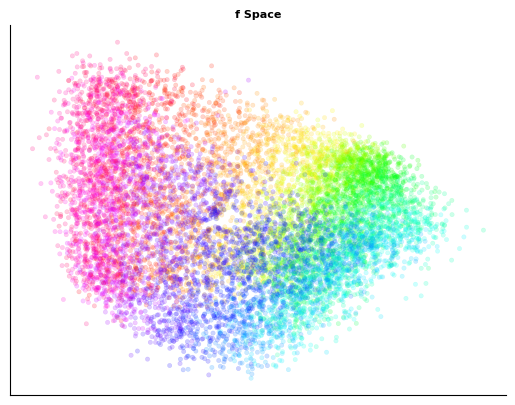

In [73]:
cells_projected = space_outputs["x_projected"].detach().numpy()
ax = axs["D"]
ax = plt.gca()
sns.scatterplot(
    x=cells_projected[:, 0],
    y=cells_projected[:, 1],
    ax=ax,
    alpha=0.2,
    edgecolor=None,
    s=10,
    c=phases,
    cmap="hsv",
)
ax.set_title("f Space")
# remove ticks
ax.set_xticks([])
ax.set_yticks([])
to_save["f_space_data"] = {
    "x": cells_projected[:, 0],
    "y": cells_projected[:, 1],
    "color": phases,
    "pseudotimes": pseudotimes,
}

In [74]:
ax = axs["E"]
plotting.modify_axis_labels(ax=ax, axis="both", step=0.5)
sns.histplot(x=phases, y=thetas, bins=50, cmap="rocket_r", ax=ax)
ax.plot(
    [-np.pi, np.pi], [-np.pi, np.pi], color="lightgray", linestyle="--", linewidth=1
)
ax.set_ylabel("Inferred Phase")
ax.set_xlabel("Simulated Phase")
ax.set_title("Phase Inference Accuracy")
np.abs(utils.normalize_angles(thetas - phases)).mean()
to_save["phase_inference_data"] = {
    "x": phases,
    "y": thetas,
}

In [75]:
# save to_save
import pickle

with open("data/simulation_continuous_without_z.pkl", "wb") as f:
    pickle.dump(to_save, f)

In [76]:
mu_pred, theta_pred = simulation.get_mu_pred(
    model, generative_outputs, space_outputs, results_shifts, n_theta=mu_gt.shape[2]
)
theta_pred = theta_pred * results_shifts["direction"] - results_shifts["shift"]

In [77]:
mu_pred.shape

(10000, 98, 100)

In [78]:
ax = axs["F"]
pearson_per_cell_genes = pearsonr(np.log2(mu_pred), np.log2(mu_gt), axis=-1)[0]
sns.histplot(
    pearson_per_cell_genes[:, model.rhythmic_gene_names != "FEN1"].flatten(),
    bins=100,
    ax=ax,
)
ax.set_xlabel("Pearson Correlation Coefficient")
ax.set_title("Expression Profiles Correlations")

Text(0.5, 1.0, 'Expression Profiles Correlations')

In [79]:
ax = axs["G"]
sns.histplot(
    x=lambda_vals, y=generative_outputs["lambda"].flatten().detach().numpy(), ax=ax
)
ax.set_xlabel("Simulated λ")
ax.set_ylabel("Inferred λ")
ax.set_title("Inferred λ Accuracy")

Text(0.5, 1.0, 'Inferred λ Accuracy')

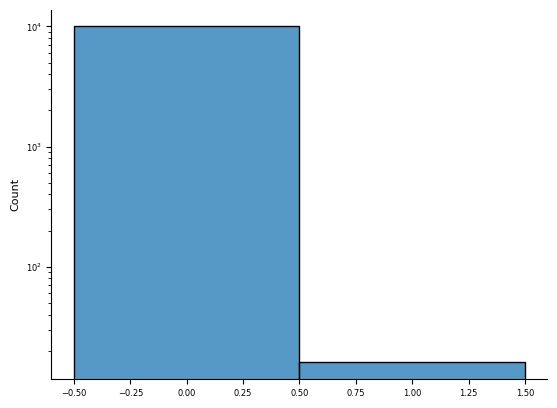

In [80]:
sns.histplot(x=adata[:, "FEN1"].layers["counts"].toarray().flatten(), discrete=True)
plt.yscale("log")

In [81]:
# create a 10000,n_genes array with the pseudotimes
discrete_gt = pd.qcut(
    (
        np.log2(mu_gt[:, ::3, :]).mean(axis=2)
        - np.log2(mu_gt[:, ::3, :]).mean(axis=2).mean(axis=0)
    ).flatten(),
    100,
)
discrete_gt = [x.mid for x in discrete_gt]
i = [i for i in range(0, mu_gt.shape[1], 3)]
ax = axs["H"]
sns.lineplot(
    x=discrete_gt,
    y=(
        np.log2(mu_pred[:, ::3, :]).mean(axis=2)
        - np.log2(mu_pred[:, ::3, :]).mean(axis=2).mean(axis=0)
    ).flatten(),
    ax=ax,
    errorbar="sd",
)
ax.plot([-2, 2], [-2, 2], color="black", linestyle="--", linewidth=1)
ax.set_xlabel("Simulated Δμ ")
ax.set_ylabel("Inferred Δμ")
ax.set_title("Inferred Δμ Accuracy")

Text(0.5, 1.0, 'Inferred Δμ Accuracy')

In [82]:
def plot_gene_expression_profile(
    ax, gene_name, mu_values, gene_names, type_label="Simulated", max_value=None
):
    cmap = sns.cubehelix_palette(as_cmap=True)
    sns.lineplot(
        np.log2(mu_values[::20, gene_names == gene_name].squeeze().T),
        legend=False,
        dashes=False,
        alpha=1,
        linewidth=2,
        palette=sns.cubehelix_palette(n_colors=500),
        ax=ax,
    )
    # Add colorbar with rainbow colormap

    norm = plt.Normalize(vmin=0, vmax=1)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label="Pseudotime")
    cbar.ax.set_yticklabels([])
    ax.set_ylabel(f"{type_label} log2 Expression")
    ax.set_title(f"{type_label} Expression Profile for {gene_name}")
    ax.set_xticks([])
    ax.set_xlabel("Phase")
    if max_value is not None:
        ax.set_ylim(top=max_value)


plot_gene_expression_profile(
    axs["I"],
    "TOP2A",
    mu_gt,
    model.rhythmic_gene_names,
    type_label="Simulated",
    max_value=-8,
)
plt.show()
plot_gene_expression_profile(
    axs["J"],
    "TOP2A",
    mu_pred,
    model.rhythmic_gene_names,
    type_label="Predicted",
    max_value=-8,
)

In [83]:
plot_helpers.label_panels_mosaic(
    fig, axs, mosaic, xloc=[0.02, 0, 0, 0], yloc=[1, 1, 1.1, 1]
)

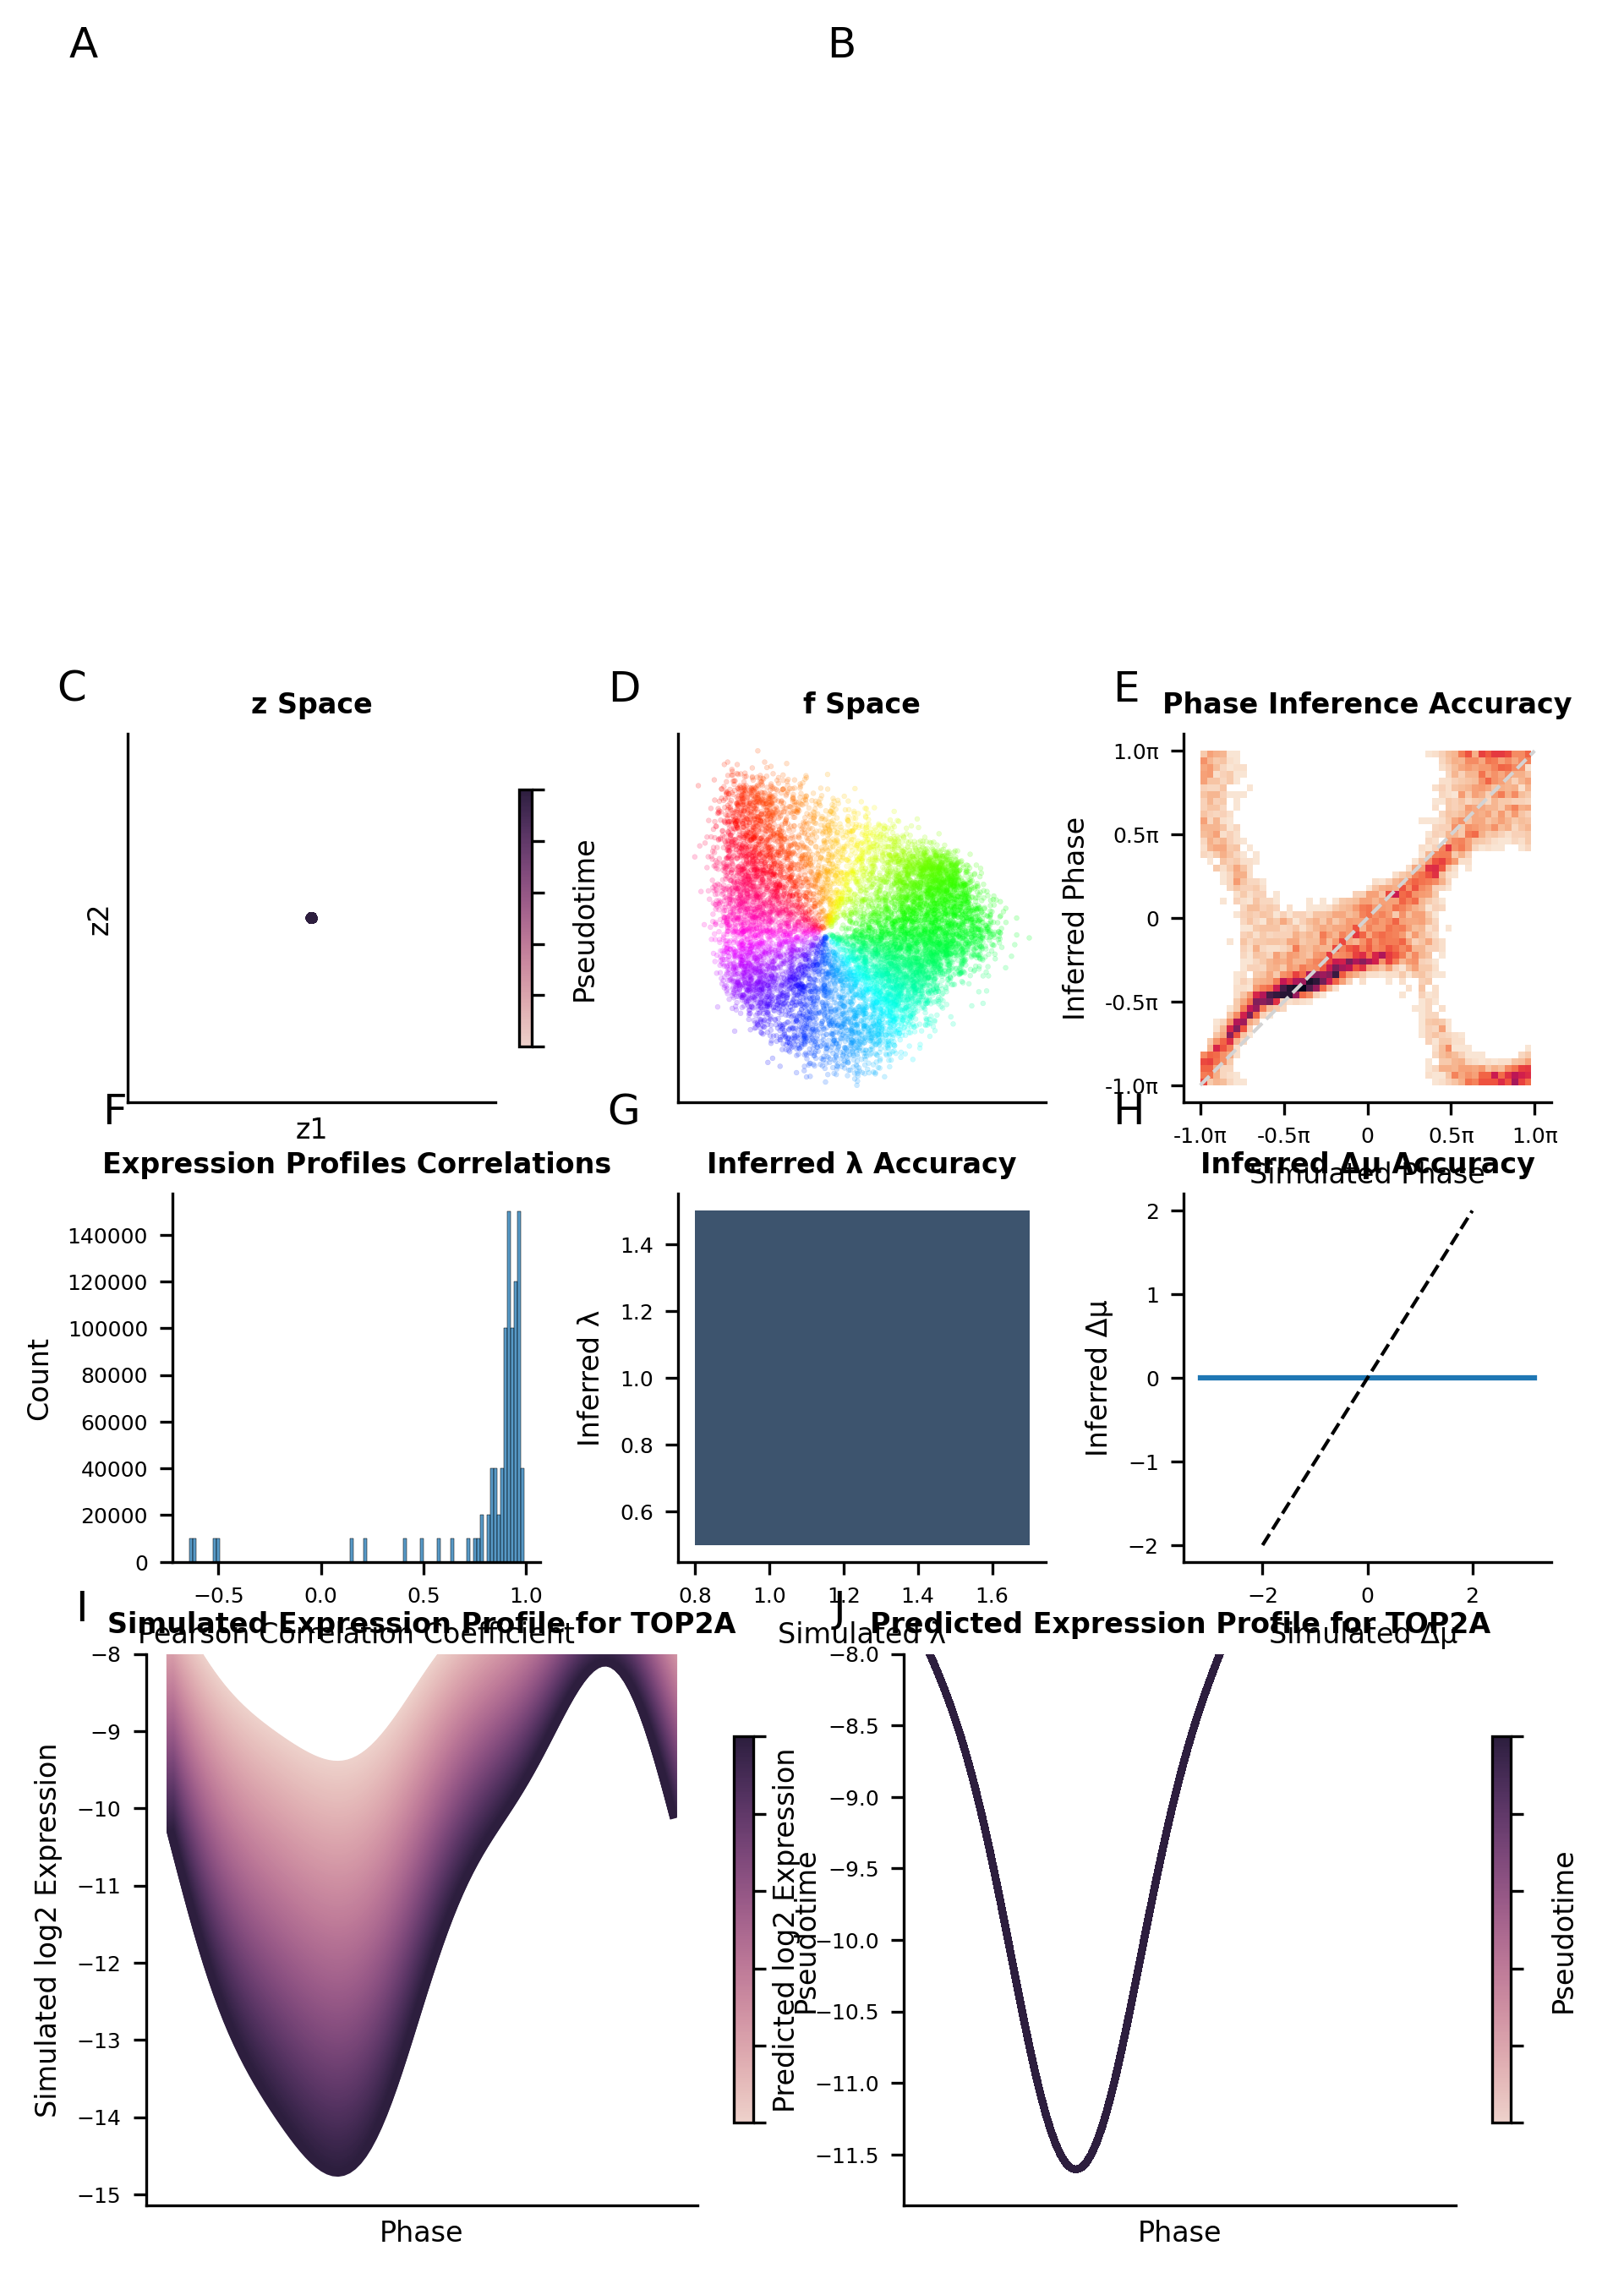

In [84]:
fig